In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from src.features import remove_outliers
from src.models.PhysicalModel import PhysicalModel
from src.models.BehaviourTransformer import BehaviourTransformer


rc = {
    "font.sans-serif": ["Fira Sans Condensed", "Arial"],
    "lines.linewidth": 2.5,
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.linewidth": 1.5,
    "axes.titleweight": "bold",
    "axes.titlelocation": "left",
    "legend.edgecolor": "none",
    # "legend.frameon": False,
    "legend.title_fontsize": 0,
    "xtick.bottom": True,
    "axes.edgecolor": ".15",
    "figure.figsize": [8.0, 5.0],
    "axes.spines.bottom": True,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
}
sns.set_theme( 
    style="whitegrid",
    context="talk",
    rc=rc
)

pd.set_option('display.max_columns', None)

TRUE_COLOR = "b"
PHYSICAL_COLOR = "g"
COMPOUND_COLOR = sns.color_palette()[1]

TRUE_STYLE = "solid"
PHYSICAL_STYLE = "dashed"
COMPOUND_STYLE = "dashdot"

In [2]:
# from src.features import load_trips
# temp = load_trips(['M3_VH', 'M3_HH', 'CPH1_HH', 'CPH1_VH', 'CPH6_VH', 'CPH6_HH'], trips='all', sampling='1s')
# temp.to_parquet("../data/processed/all_trips.parquet")
# del temp

In [3]:
all_data = pd.read_parquet("../data/processed/all_trips.parquet")

# df = all_data.query("route in ['M3_VH', 'CPH1_HH', 'CPH1_VH']")
# df_test = all_data.query("route in ['CPH6_VH', 'CPH6_HH']")
# train_route = "M3"
# train_trip = 7448
# test_route = "CPH6"
# test_trip = 13175

# df = all_data.query("route == 'CPH1_VH' and trip in [7792, 7805, 8040, 8042, 8227, 9289]")
# df_test = all_data.query("route == 'CPH1_VH' and trip == 10218")
# train_route = "CPH1"
# train_trip = 7792
# test_route = "CPH1"
# test_trip = 10218

df = all_data.query("route == 'M3_VH' and trip in [7448, 7895, 7995]")
df_test = all_data.query("route == 'M3_VH' and trip == 7995")
train_route = "M3"
train_trip = 7448
test_route = "M3"
test_trip = 7995

outlier_columns = ['acceleration_z',
                   'acceleration_y',
                   'acceleration_x',
                   'steering_position',
                   'steering_acceleration',
                   'traction_instant_consumption',
                   'yaw_rate',
                   'velocity']

df = remove_outliers(df, outlier_columns)
df = df.sort_index()


# df_test = remove_outliers(df_test, outlier_columns)
# df_test = df_test.sort_index()

In [4]:
features_road = ["traffic_lights", "road_signs", "speed_limit", "ped_walks", "speed_bumps", "bike_lane"]

In [5]:
behaviour_transformer = BehaviourTransformer()

df = df.merge(behaviour_transformer.adjust_acceleration(df, columns=["acceleration_x", "acceleration_y"]), 
                    left_index=True, right_index=True)

df = df.reset_index().drop_duplicates('TS_or_Distance').set_index('TS_or_Distance')

behaviour_transformer.fit(df)

physical_model = PhysicalModel()
physical_model.fit("velocity", "acceleration_y")

df = df.merge(behaviour_transformer.transform(df), left_index=True, right_index=True)\
             .assign(kW_pred=physical_model.predict(df))\
             .assign(error=lambda x: x.kW_pred - x.traction_instant_consumption)

In [6]:
df_test = df_test[~df_test.index.duplicated(keep='first')]
df_test.loc[:, features_road] = df_test[features_road].fillna(0)
df_test = df_test.dropna(how='any', axis=0)

df_test = df_test.merge(behaviour_transformer.adjust_acceleration(df_test, columns=["acceleration_x", "acceleration_y"]), 
                    left_index=True, right_index=True)

physical_model = PhysicalModel()
physical_model.fit("velocity", "acceleration_y")

df_test = df_test.merge(behaviour_transformer.transform(df_test), left_index=True, right_index=True)\
                            .assign(kW_pred=physical_model.predict(df_test))\
                            .assign(error=lambda x: x.kW_pred - x.traction_instant_consumption)

In [7]:
features = ['adjusted_acceleration_x', 'adjusted_acceleration_y', 'yaw_rate', 'velocity'] \
    + ['driver_safety_belt_reminder'] \
    + behaviour_transformer.behavioural_columns \
    + features_road \
    + behaviour_transformer.var_cols
target = "error"

In [8]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

model = lgb.LGBMRegressor()
param_grid = {
    'n_estimators': [50, 100, 150],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.],
    'max_depth': [15,20,25],
    'num_leaves': [20, 30, 40, 50, 60],
    # 'reg_alpha': [1.1, 1.2, 1.3],
    # 'reg_lambda': [1.1, 1.2, 1.3],
    # 'min_split_gain': [0.3, 0.4],
    # 'subsample': [0.7, 0.8, 0.9],
    # 'subsample_freq': [20]
}

df_cv = df[features + [target]].dropna(axis=0)
df_test_cv = df_test[features + [target]].dropna(axis=0)
cv, pred = algorithm_pipeline(df_cv[features].to_numpy(), df_test_cv[features].to_numpy(), df_cv[target].to_numpy(), df_test_cv[target].to_numpy(), model, 
                                 param_grid, cv=5)

print(cv.best_score_)
print(cv.best_params_)

model = cv.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-74.38623462742424
{'colsample_bytree': 0.7, 'max_depth': 15, 'n_estimators': 50, 'num_leaves': 20}


In [9]:
import lightgbm as lgb
model_median = lgb.LGBMRegressor(**cv.best_params_)
model_median.fit(df[features], df[target])
model_lower = lgb.LGBMRegressor(objective="quantile", alpha=0.025, **cv.best_params_)
model_lower.fit(df[features], df[target])
model_upper = lgb.LGBMRegressor(objective="quantile", alpha=0.975, **cv.best_params_)
model_upper.fit(df[features], df[target])

LGBMRegressor(alpha=0.975, colsample_bytree=0.7, max_depth=15, n_estimators=50,
              num_leaves=20, objective='quantile')

In [10]:
# import lightgbm as lgb
# model = lgb.LGBMRegressor()
# model.fit(df[features], df[target])

# import lightgbm as lgb
# model_median = lgb.LGBMRegressor()
# # model_median = lgb.LGBMRegressor(objective="quantile", alpha=0.5)
# model_median.fit(df[features], df[target])
# model_lower = lgb.LGBMRegressor(objective="quantile", alpha=0.025)
# model_lower.fit(df[features], df[target])
# model_upper = lgb.LGBMRegressor(objective="quantile", alpha=0.975)
# model_upper.fit(df[features], df[target])

# Testing

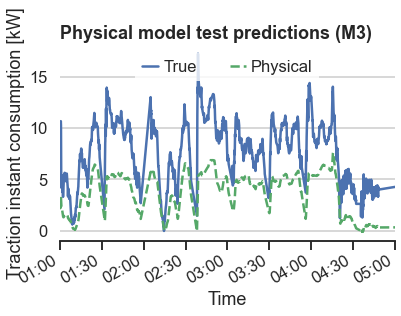

In [11]:
df_plot = df_test.query(f"`trip` == {test_trip}").drop(["route"], axis=1).rolling("5min").mean().reset_index()

fig, ax = plt.subplots()
sns.lineplot(data=df_plot, x="TS_or_Distance", y="traction_instant_consumption", label='True', ax=ax, color=TRUE_COLOR, linestyle=TRUE_STYLE)
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred", label='Physical', ax=ax, color=PHYSICAL_COLOR, linestyle=PHYSICAL_STYLE)

ax.legend(ncol=len(ax.lines), handlelength=1, handletextpad=0.3, loc="upper center")
ax.set(
    title=f'Physical model test predictions ({test_route})',
    xlabel="Time",
    ylabel="Traction instant consumption [kW]",
)
if test_trip == 7995:
    ax.set(xlim=[datetime(2021, 4, 26, 1, 0, 0), datetime(2021, 4, 26, 5, 0, 0)])
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.savefig("../figures/physical_test.pdf")
fig.savefig("../figures/physical_test.png")

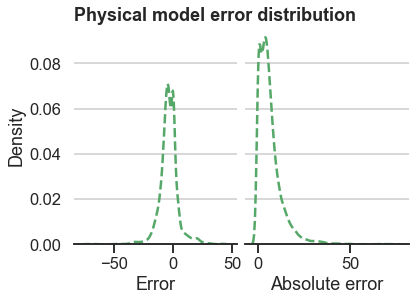

In [12]:
fig, ax = plt.subplots(ncols=2, sharey=True)
sns.kdeplot(x=df_test.error, ax=ax[0], color=PHYSICAL_COLOR, linestyle=PHYSICAL_STYLE)
sns.kdeplot(x=df_test.error.abs(), ax=ax[1], color=PHYSICAL_COLOR, linestyle=PHYSICAL_STYLE)
ax[0].set(
    title="Physical model error distribution",
    xlabel="Error",
)
ax[1].set(
    xlabel="Absolute error",
)
fig.subplots_adjust(wspace=0.05, hspace=0)
fig.savefig("../figures/physical_error.pdf")
fig.savefig("../figures/physical_error.png")

In [13]:
df['error_pred'] = model_median.predict(df[features])
df['error_pred_lower'] = model_lower.predict(df[features])
df['error_pred_upper'] = model_upper.predict(df[features])
df['kW_pred_final'] = df['kW_pred'] - df['error_pred']
df['kW_pred_final_lower'] = df['kW_pred'] - df['error_pred_lower']
df['kW_pred_final_upper'] = df['kW_pred'] - df['error_pred_upper']


df_test['error_pred'] = model_median.predict(df_test[features])
df_test['error_pred_lower'] = model_lower.predict(df_test[features])
df_test['error_pred_upper'] = model_upper.predict(df_test[features])
df_test['kW_pred_final'] = df_test['kW_pred'] - df_test['error_pred']
df_test['kW_pred_final_lower'] = df_test['kW_pred'] - df_test['error_pred_lower']
df_test['kW_pred_final_upper'] = df_test['kW_pred'] - df_test['error_pred_upper']


# df_test['kW_pred_final'] = model.predict(df_test[features])

In [14]:
from sklearn.metrics import r2_score

print(r2_score(df['traction_instant_consumption'], df['kW_pred_final']))
print(r2_score(df_test['traction_instant_consumption'], df_test['kW_pred_final']))

0.7531381140702974
0.8457030781704317


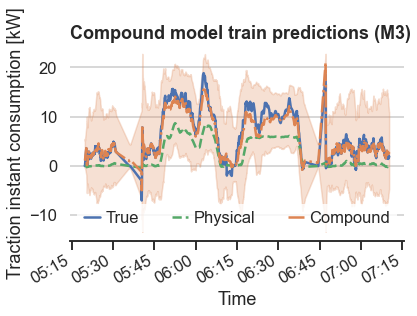

In [15]:
df_plot = df.query(f"`trip` == {train_trip}").drop(["route"], axis=1).rolling("2min").mean().reset_index()

fig, ax = plt.subplots()



sns.lineplot(data=df_plot, x="TS_or_Distance", y="traction_instant_consumption", label='True', color=TRUE_COLOR, linestyle=TRUE_STYLE)
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred", label='Physical', color=PHYSICAL_COLOR, linestyle=PHYSICAL_STYLE)
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred_final", label='Compound', color=COMPOUND_COLOR, linestyle=COMPOUND_STYLE)
ax.fill_between(x=df_plot["TS_or_Distance"], y1=df_plot["kW_pred_final_lower"], y2=df_plot["kW_pred_final_upper"], color=COMPOUND_COLOR, alpha=0.25)

ax.legend(ncol=len(ax.lines), handlelength=1, handletextpad=0.3, loc="lower center")
ax.set(
    title=f'Compound model train predictions ({train_route})',
    xlabel="Time",
    ylabel="Traction instant consumption [kW]",
)
if train_trip == 7792:
    ax.set(xlim=[datetime(2021, 4, 22, 1, 0, 0), datetime(2021, 4, 22, 3, 15, 0)])
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.savefig("../figures/compound_train.pdf")
fig.savefig("../figures/compound_train.png")


In [16]:
# df_plot = df.query(f"`trip` == {train_trip}").drop(["route"], axis=1).rolling("2min").mean().reset_index()

# fig, ax = plt.subplots()
# sns.lineplot(data=df_plot, x="TS_or_Distance", y="traction_instant_consumption", label='True', color=TRUE_COLOR, linestyle=TRUE_STYLE)
# sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred", label='Physical', color=PHYSICAL_COLOR, linestyle=PHYSICAL_STYLE)
# sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred_final", label='Compound', color=COMPOUND_COLOR, linestyle=COMPOUND_STYLE)

# ax.set(
#     # title='Physical and compound model predictions on train set',
#     xlabel="Time",
#     ylabel="Traction instant consumption [kW]",
# )
# if train_trip == 7792:
#     ax.set(xlim=[datetime(2021, 4, 22, 1, 0, 0), datetime(2021, 4, 22, 3, 15, 0)])
# fig.autofmt_xdate()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.savefig("../figures/compound_train.pdf")
# fig.savefig("../figures/compound_train.png")

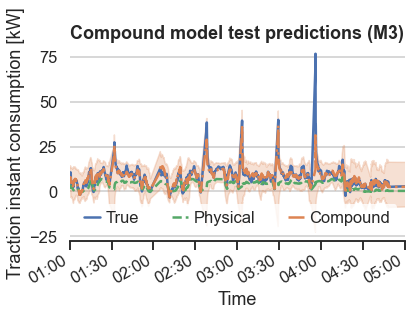

In [17]:
df_plot = df_test.query(f"`trip` == {test_trip}").drop(["route"], axis=1).rolling("2min").mean().reset_index()

fig, ax = plt.subplots()
sns.lineplot(data=df_plot, x="TS_or_Distance", y="traction_instant_consumption", label='True', color=TRUE_COLOR, linestyle=TRUE_STYLE)
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred", label='Physical', color=PHYSICAL_COLOR, linestyle=PHYSICAL_STYLE)
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred_final", label='Compound', color=COMPOUND_COLOR, linestyle=COMPOUND_STYLE)
ax.fill_between(x=df_plot["TS_or_Distance"], y1=df_plot["kW_pred_final_lower"], y2=df_plot["kW_pred_final_upper"], color=COMPOUND_COLOR, alpha=0.25)

ax.legend(ncol=len(ax.lines), handlelength=1, handletextpad=0.3, loc="lower center")
ax.set(
    title=f'Compound model test predictions ({test_route})',
    xlabel="Time",
    ylabel="Traction instant consumption [kW]",
)
if test_trip == 7995:
    ax.set(xlim=[datetime(2021, 4, 26, 1, 0, 0), datetime(2021, 4, 26, 5, 0, 0)])
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.savefig("../figures/compound_test.pdf")
fig.savefig("../figures/compound_test.png")

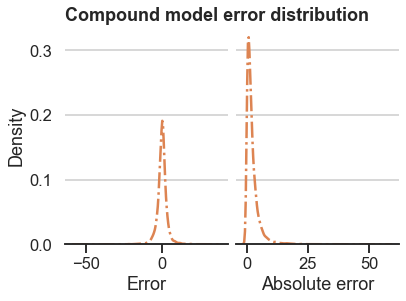

In [18]:
fig, ax = plt.subplots(ncols=2, sharey=True)
sns.kdeplot(x=df_test.assign(error=lambda x: x.kW_pred_final - x.traction_instant_consumption).error, ax=ax[0], color=COMPOUND_COLOR, linestyle=COMPOUND_STYLE)
sns.kdeplot(x=df_test.assign(error=lambda x: x.kW_pred_final - x.traction_instant_consumption).error.abs(), ax=ax[1], color=COMPOUND_COLOR, linestyle=COMPOUND_STYLE)
ax[0].set(
    title="Compound model error distribution",
    xlabel="Error",
)
ax[1].set(
    xlabel="Absolute error",
)
fig.subplots_adjust(wspace=0.05, hspace=0)
fig.savefig("../figures/compound_error.pdf")
fig.savefig("../figures/compound_error.png")

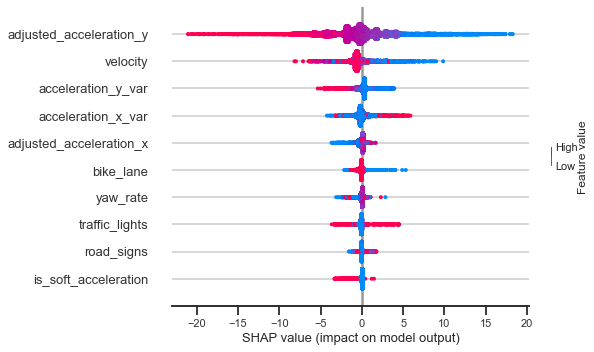

In [19]:
import shap

explainer = shap.TreeExplainer(model_median)
shap_values = explainer.shap_values(df_test[features])

shap.summary_plot(shap_values, df_test[features], max_display=10, show=False)
plt.savefig("../figures/shap.pdf")
plt.savefig("../figures/shap.png")